In [1]:
import os
from pathlib import Path
from skimage import io
import matplotlib.pyplot as plt

from imagegrains import data_loader, segmentation_helper, grainsizing,plotting

import warnings
warnings.filterwarnings("ignore")

## Measure grain sizes in labels and predictions

Grain sizes are measured for all image files of masks in `PATH` with a specific format (`mask_format`, default = tif). `PATH` can have sub-folders named 'test', 'train'. If `do_subfolders == True` any existing sub-folder will be used.   
- A string (`mask_str`) for filtering file names can be used.
- Alternatives to the default ellipsoid fitting are available (can be specified  with `fit_method`).

Parameters
----------
`INP_DIR` (str) - path to the dataset.  
`mask_format` (str (optional, default = 'tif')) - format of the mask images.  
`mask_str` (str (optional, default = '')) - string that is contained in the mask images; e.g., '_mask' for lables, '_pred' for predictions  
`TAR_DIR` (str (optional, default = '')) - path to the target directory  
`filters` (dict (optional, default = None)) - dictionary of filters to apply to the grains  
`mute` (bool (optional, default = False)) - mute the console output.  
`OT` (float (optional, default =.5)) - Angular tolerance threshold for b-axis detection during outline fitting in degree (°).  
`properties` (list (optional, default = ['label', 'area', 'orientation', 'minor_axis_length', 'major_axis_length', 'centroid', 'local_centroid'])) - list of properties to be extracted from the masks.   
`fit_method` (str (optional, default = '')) - method to fit the grain outlines. Options are,'convex_hull','mask_outline'. If fit_method is not specified, ellipsoidal fit will be used. ! Please note that using 'convex_hull' or 'mask_outline' will be slow.  
`return_results` (bool (optional, default =False)) - return the results as a list of pandas dataframes.  
`save_results` (bool (optional, default = True)) - save the results as csv files.  
`do_subfolders` (bool (optional, default = False)) - if True, the function will also measure 

In [3]:
#set path to predicted masks (segmentation model output)
PATH = "F:/demo/"
#optional filters for grain size measuring
filters= {
    'edge':[True,.1],'px_cutoff':[True,12]
    }
#optional properties for regionprops
properties=['label','area','centroid','major_axis_length','minor_axis_length']

In [4]:
#measure grain sizes of ground truth
lbl_grains,lbl_res_props,lbl_IDs = grainsizing.batch_grainsize(PATH,filters=filters,mask_str='_mask',properties=properties,mute=True,return_results=True,do_subfolders=False)

F:/demo//grid_resampled_preds: 0file [00:00, ?file/s]
F:/demo//train: 100%|██████████| 6/6 [00:00<00:00,  6.49file/s]


In [5]:
#measure grain sizes of predictions with filter tags
pred_grains,pred_res_props,pred_IDs = grainsizing.batch_grainsize(PATH,filters=filters,mask_str='fh_pred',properties=properties,mute=True,return_results=True,do_subfolders=False)
pred_b_grains,pred_b_res_props,pred_b_IDs = grainsizing.batch_grainsize(PATH,filters=filters,mask_str='fh_boosted_pred',properties=properties,mute=True,return_results=True,)

F:/demo//train: 100%|██████████| 6/6 [00:00<00:00, 10.55file/s]
F:/demo//grid_resampled_preds: 0file [00:00, ?file/s]
F:/demo//train: 100%|██████████| 6/6 [00:00<00:00, 10.59file/s]


### Load predictions, labels and images

In [6]:
#get image-, label- and pred-paths
imgs,lbls,_ = data_loader.dataset_loader(PATH,label_str='mask',pred_str='fh_pred')
_,_,preds = data_loader.dataset_loader(PATH,pred_str='fh_pred')
_,_,preds_boosted = data_loader.dataset_loader(PATH,pred_str='fh_boosted_pred')
#map to train/test split
preds = segmentation_helper.map_preds_to_imgs(preds,imgs,p_string='_fh_pred')
preds_boosted = segmentation_helper.map_preds_to_imgs(preds_boosted,imgs,p_string='_fh_boosted_pred')
#set plot elements
elements= ['image','mask','ellipse_b','ellipse_a','ellipse']

### Re-order the results to match the order of the images

In [7]:
pred_grains,pred_res_props,pred_IDs= grainsizing.map_grain_res_to_img(imgs,pred_grains,pred_res_props,pred_IDs,p_string='_fh_pred')
pred_b_grains,pred_b_res_props,pred_b_IDs= grainsizing.map_grain_res_to_img(imgs,pred_b_grains,pred_b_res_props,pred_b_IDs,p_string='_fh_boosted_pred')

### Plot grains, approximations and axes

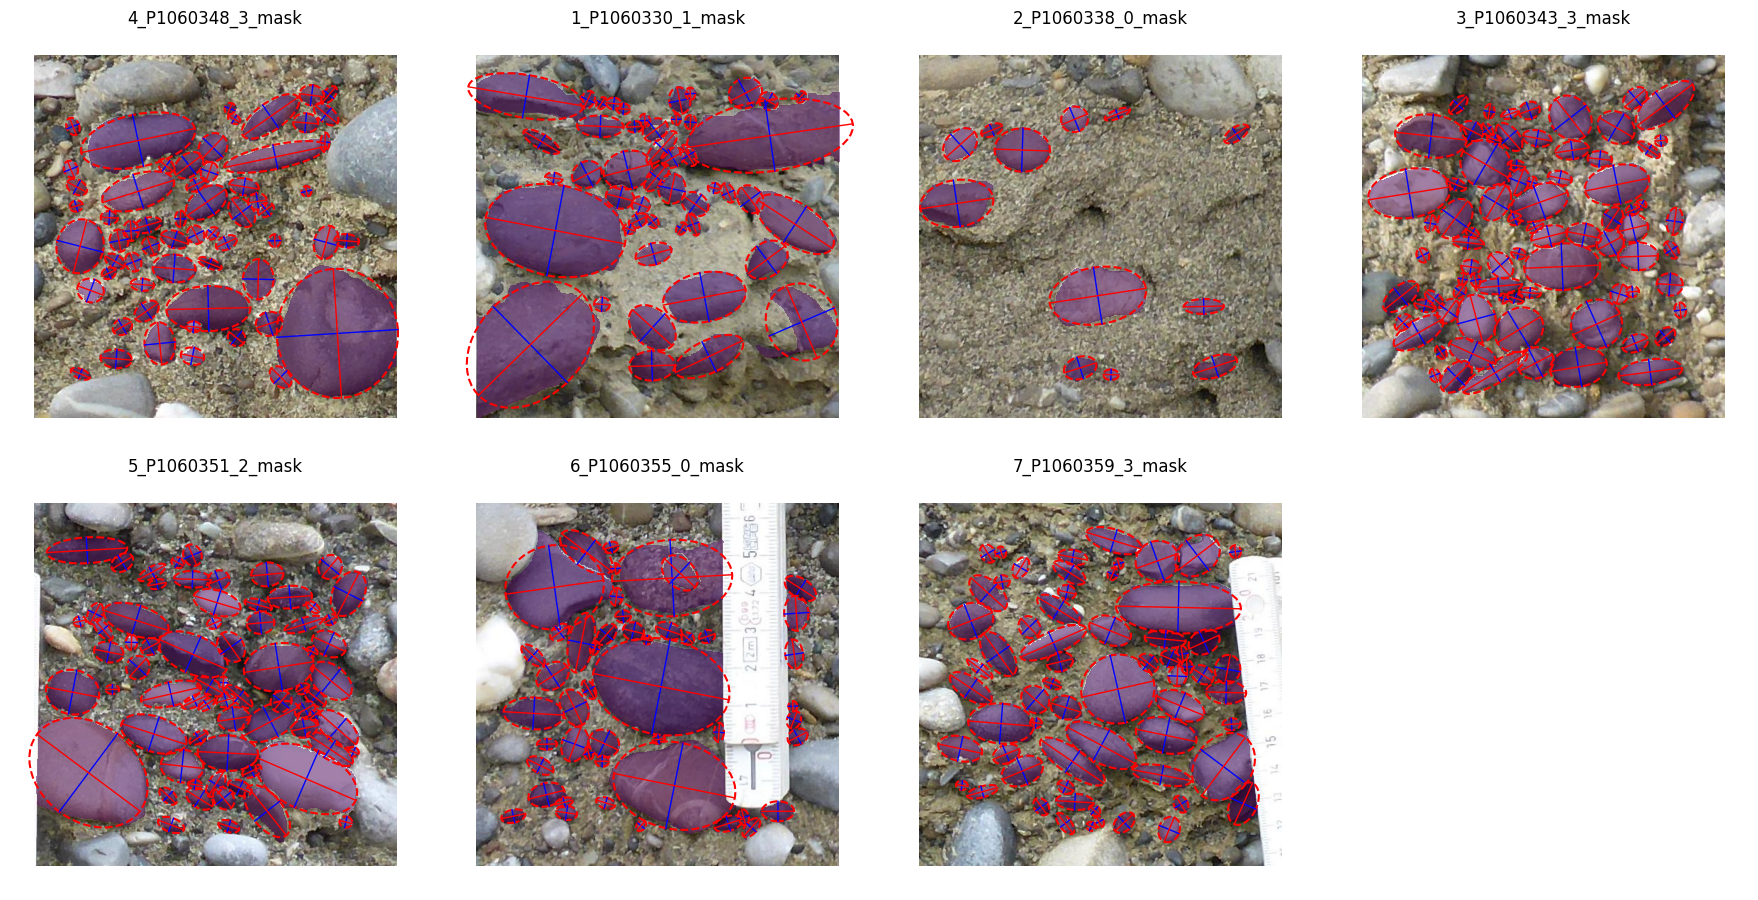

In [8]:
label_grains = plotting.inspect_dataset_grains(imgs,lbls,res_props=lbl_res_props)

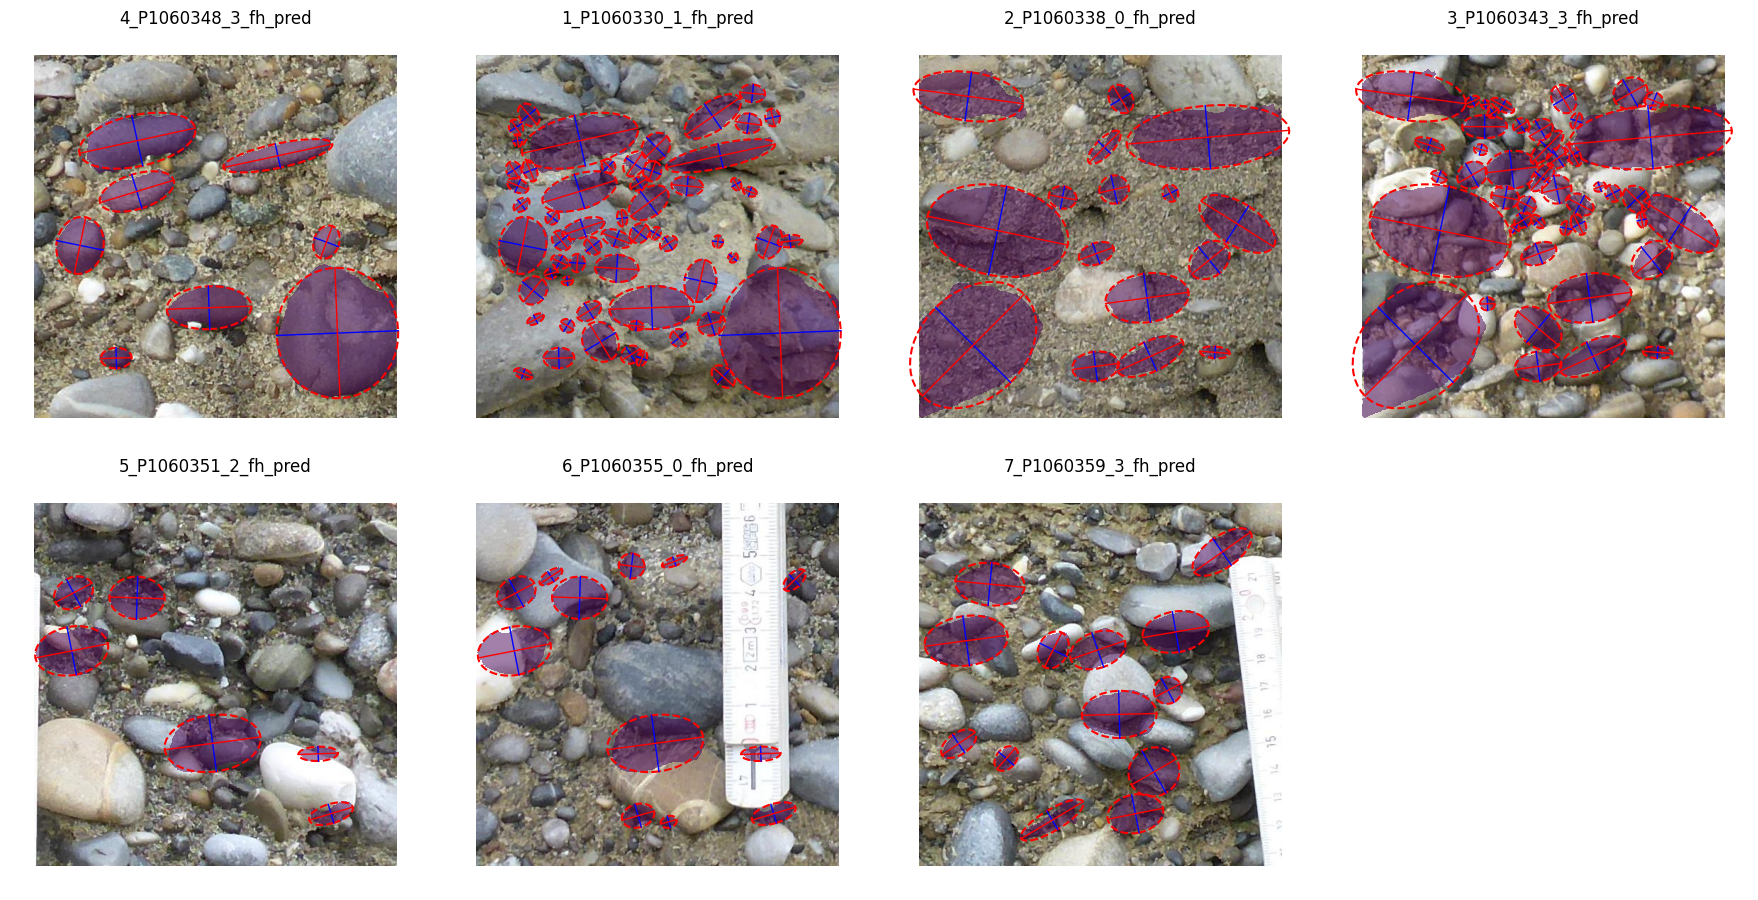

In [9]:
prediction_grains = plotting.inspect_dataset_grains(imgs,preds,res_props=pred_res_props)

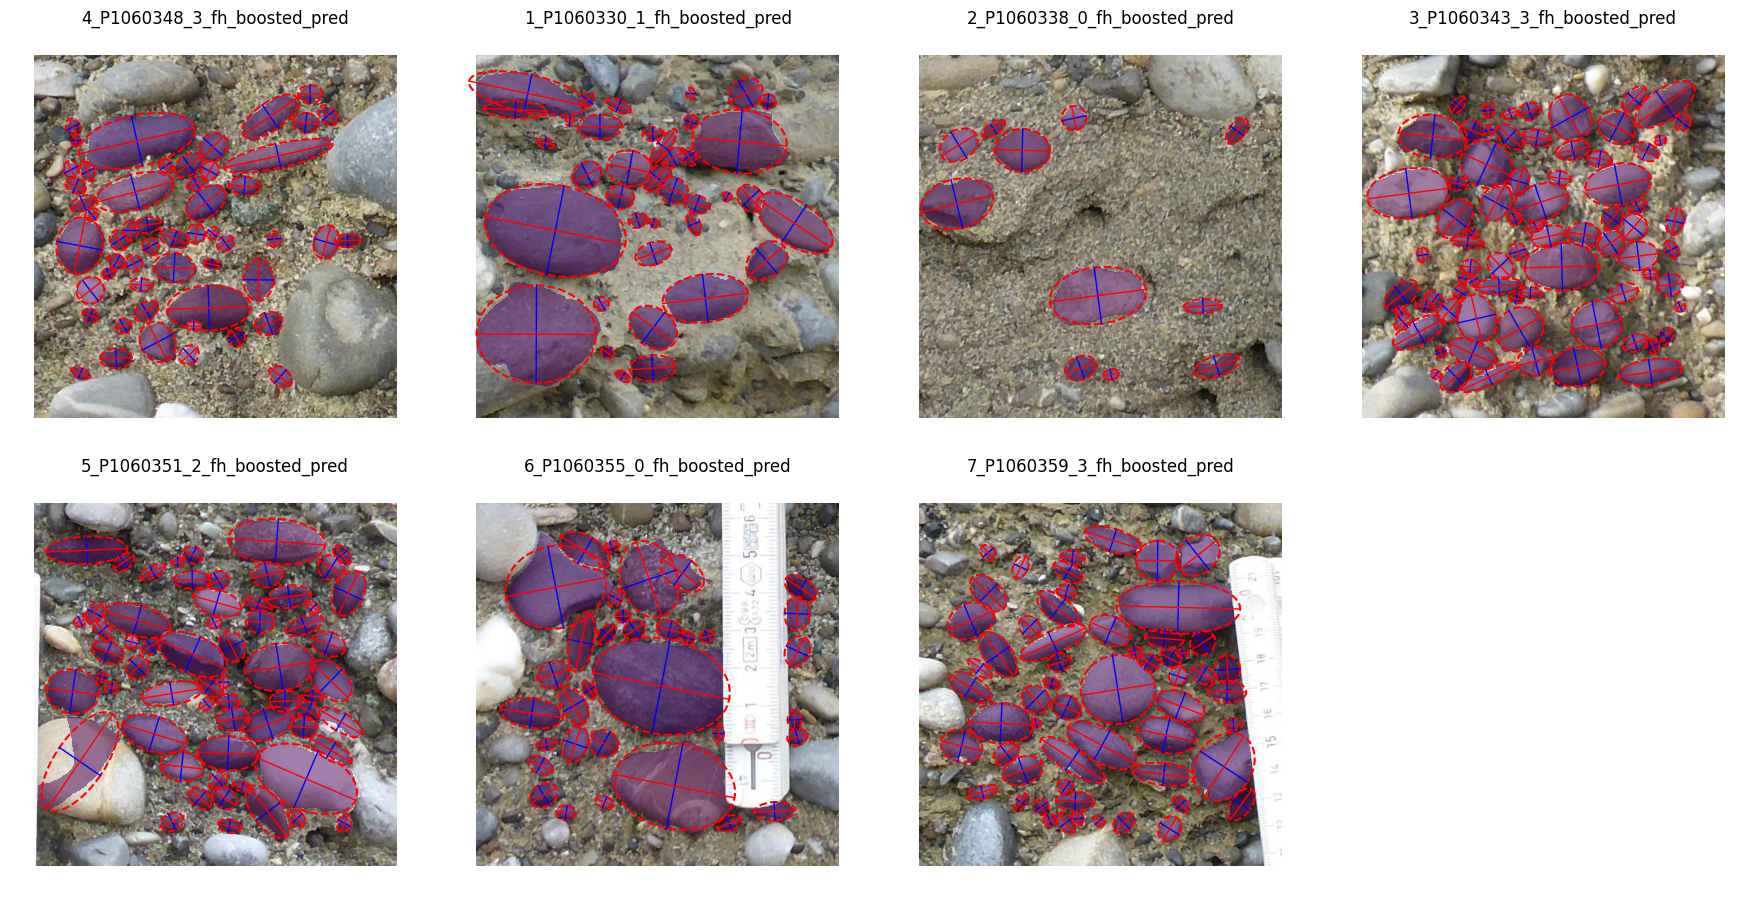

In [10]:
prediction_grains_2 = plotting.inspect_dataset_grains(imgs,preds_boosted,res_props=pred_b_res_props)

## Re-scale grain sizes with image resolution

In [11]:
#avergae image resolution
resolution = 0.39
grainsizing.re_scale_dataset(PATH,resolution=resolution,gsd_str='_grains',return_results=True,save_gsds=True);

# camera parameters for estimating the image resolution (optional) - can be passed to `grainsizing.re_scale_dataset()`
camera_parameters = {
    'image_distance_m': [], 
    'focal_length_mm': [],
    'sensorH_mm': [],
    'sensorW_mm': [],
    'pixelsW':[],
    'pixelsH':[],
    }

## Optional: Resample the grains with a regular grid or randomly

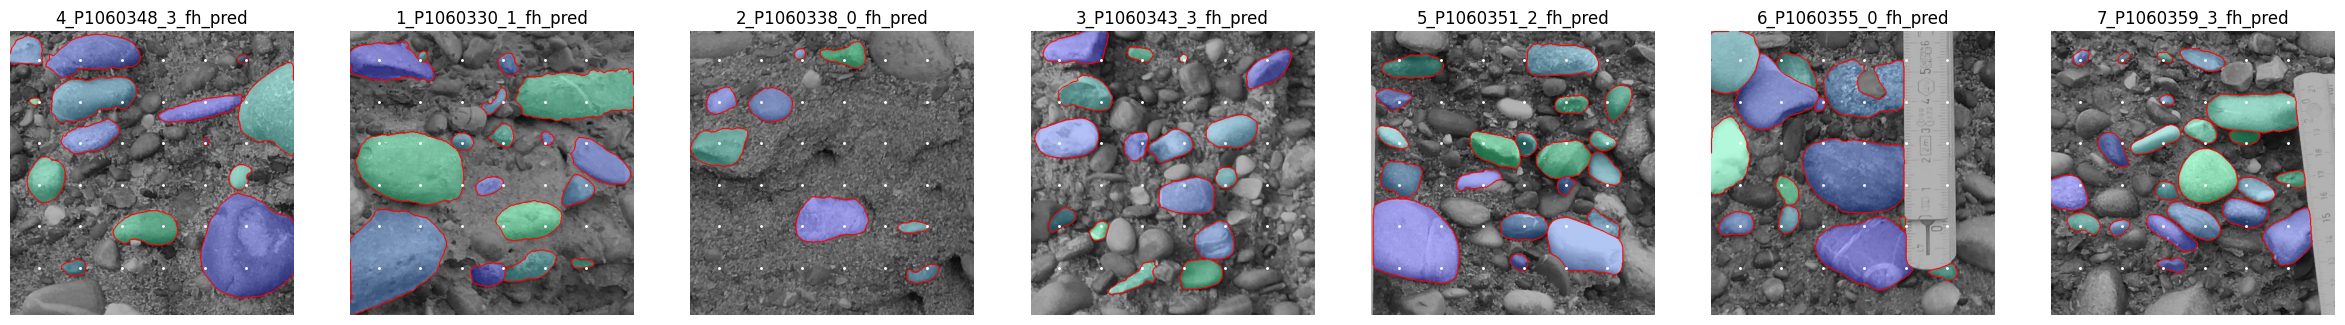

In [12]:
#create output folder
os.makedirs(PATH+'/grid_resampled_preds/',exist_ok=True)

plt.figure(figsize=(30,20))
for i,masks in enumerate(preds):
    plt.subplot(1,len(preds),i+1)
    #get ID from file name
    ID = Path(masks).stem
    #load masks from file
    mask = io.imread(masks)
    #resample mask to grid
    grid_resampled,xx,yy = grainsizing.resample_masks(mask,filters=filters,grid_size=75,mute=True)
    #plot mask and resampled mask
    plotting.plot_single_img_mask(io.imread(imgs[i]),grid_resampled,ID)
    #plot grid
    plt.scatter(yy,xx,marker='.',color='w',s=5)
    #save resampled mask to file 
    io.imsave(PATH+'/grid_resampled_preds/'+ID+'_resampled.tif',grid_resampled)

## Optional: Save individual grains (masks, sliced image, outline) to file

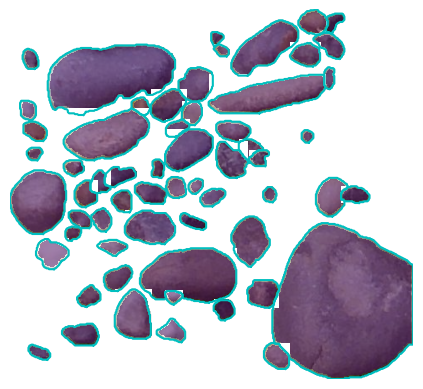

In [13]:
#single image
grainsizing.export_grain_outline(io.imread(lbls[0]),img=io.imread(imgs[0]),TAR_DIR='F:/git/grain_seg_ml/test/_1_best/grains/',props=lbl_res_props[0],ID='demo',plot_summary=True)
#full dataset
TAR_DIR='F:/git/grain_seg_ml/test/_1_best/grains/'
grainsizing.batch_outline(lbls,imgs,prop_l=lbl_res_props,TAR_DIR=TAR_DIR,filters= filters)